# NOTE

This notebook is best viewed with some jupyter extensions:

```
# snippet of impartant parts of `jupyter nbextension list`
Known nbextensions:
    notebook section
      ExecuteTime
      collapsible_headings
      hide_input
      toc2
```

After `Imports` and `Setup` `Model testing` can be executed.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NOTE" data-toc-modified-id="NOTE-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NOTE</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Hyper-parameter-search-learning-rate" data-toc-modified-id="Hyper-parameter-search-learning-rate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyper-parameter search learning rate</a></span></li><li><span><a href="#Train-model-using-K-=-1,2,3,4,5" data-toc-modified-id="Train-model-using-K-=-1,2,3,4,5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train model using K = 1,2,3,4,5</a></span></li><li><span><a href="#Test-on-a-bigger-grid" data-toc-modified-id="Test-on-a-bigger-grid-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test on a bigger grid</a></span></li><li><span><a href="#Plotting-solutions-for-domain-shapes" data-toc-modified-id="Plotting-solutions-for-domain-shapes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting solutions for domain shapes</a></span><ul class="toc-item"><li><span><a href="#Plot-Square-Domain" data-toc-modified-id="Plot-Square-Domain-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plot Square Domain</a></span></li><li><span><a href="#Plot-L-shape" data-toc-modified-id="Plot-L-shape-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Plot L shape</a></span></li></ul></li><li><span><a href="#Error-evolution-with-iterations" data-toc-modified-id="Error-evolution-with-iterations-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Error evolution with iterations</a></span></li><li><span><a href="#Model-testing" data-toc-modified-id="Model-testing-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model testing</a></span><ul class="toc-item"><li><span><a href="#Tables-plots-for-report" data-toc-modified-id="Tables-plots-for-report-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Tables plots for report</a></span></li></ul></li></ul></div>

# Imports

In [63]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import os
from importlib import reload
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display

import nnpde.iterative_methods as im
from nnpde.metrics import least_squares_loss as LSE
from nnpde import geometries, helpers
from nnpde.utils.logs import enable_logging, logging 
from nnpde.problems import DirichletProblem 
from nnpde.utils import plots
import nnpde.model as M 
import nnpde.model_testing as MT
import nnpde.problems as PDEF
from nnpde.grid_search import grid_search

# Setup

In [3]:
enable_logging(20)

seed = 9 # Does not give problems
torch.manual_seed(seed)
np.random.seed(seed)

2018-12-30 12:10:53,464 - root - INFO - logs - logging enabled for level: 20


In [4]:
# Define train dimension: NxN
N = 16

# For each problem instance define number of iteration to perform to obtain the solution
nb_problem_instances = 50
problem_instances = [DirichletProblem(k=k) for k in np.random.randint(1, 20, nb_problem_instances)]

# Net parameters, will also be used further down.
base_parameters = {
    "nb_layers": 3,
    "max_epochs": 200,
    "batch_size": 10,
    "stable_count": 10,
    "random_seed": 9,
}

# SGD
grid_parameters = {
    "learning_rate": np.logspace(start=-6, stop=-4, num=7), #num=7 is good since it contains 1e-5
}

# Hyper-parameter search learning rate

In [ ]:
def grid_search_wrapper(base_parameters, grid_search_parameters):
    return grid_search(mdl=M.JacobyWithConv,
                       base_parameters=base_parameters,
                       grid_search_parameters=grid_search_parameters,
                       problem_instances=problem_instances)

In [ ]:
# Took 3m 13s on a Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz
hyper_models = grid_search_wrapper(base_parameters, grid_parameters) \
    + grid_search_wrapper(base_parameters, {"optimizer": ["Adadelta"]})

In [ ]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
hyper_fig = plt.figure()

# Plot SGD
i = 0
for model in hyper_models[:-1]:  
    n_epoch = np.arange(np.shape(model.losses)[0])
    plt.semilogy(n_epoch, 
                 model.losses, 
                 color=colors[i], 
                 linewidth=1, 
                 linestyle="-", 
                 marker=(i+2, 0, 0), 
                 markevery=10, 
                 label = f'$\gamma= {model.learning_rate:.2e} $')
    i += 1

# Plot Adadelta
n_epoch = np.arange(np.shape(hyper_models[-1].losses)[0])
plt.semilogy(n_epoch, hyper_models[-1].losses, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=10,label='Adadelta')

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n epochs', fontsize=14)
plt.ylabel('Total loss [-]', fontsize=14)
#plt.xlim([0, base_parameters['max_epochs']])
#plt.ylim([0, 200])
plt.title('Loss evolution for different learning rates $\gamma$ \n $K=3$, $|\mathcal{D}|=50$, $|\mathcal{B}|=10$, max epochs=200')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

#hyper_fig.savefig('../report/figs/hyper.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Train model using K = 1,2,3,4,5

In [8]:
base_parameters

{'nb_layers': 3,
 'max_epochs': 200,
 'batch_size': 10,
 'stable_count': 10,
 'random_seed': 9}

In [11]:
reload(M)

params = {**base_parameters, **{'max_epochs': 1000, 'optimizer': 'Adadelta'}}
models = grid_search_wrapper(params, {'nb_layers': range(1, 6)})

#models = [M.JacobyWithConv(**{**params, 'nb_layers': nb_layers}).fit(problem_instances) for nb_layers in [1,2,3,4,5]]
#models = [M.JacobyWithConv(**{**params, 'nb_layers': nb_layers}).fit(problem_instances) for nb_layers in [1,2,3,4,5]]

2018-12-20 20:28:56,548 - root - INFO - model - Using optimizer Adadelta
2018-12-20 20:28:56,725 - root - INFO - model - Training with max_epochs: 500, tol: 1e-06. Initial loss is 16156.76171875
2018-12-20 20:28:57,022 - root - INFO - model - iter 0 with total loss 4020.325927734375
2018-12-20 20:29:28,979 - root - INFO - model - iter 100 with total loss 330.5577392578125
2018-12-20 20:30:00,568 - root - INFO - model - iter 200 with total loss 330.51593017578125
2018-12-20 20:30:28,184 - root - INFO - model - iter 300 with total loss 330.52191162109375
2018-12-20 20:30:59,289 - root - INFO - model - iter 400 with total loss 330.525146484375
2018-12-20 20:31:37,099 - root - INFO - model - Convergence reached in 499 epochs with total loss 330.5162353515625
2018-12-20 20:31:37,101 - root - INFO - model - Using optimizer Adadelta
2018-12-20 20:31:37,278 - root - INFO - model - Training with max_epochs: 500, tol: 1e-06. Initial loss is 1111510.625
2018-12-20 20:31:37,807 - root - INFO - mod

2018-12-20 20:49:14,363 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:49:14,398 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,398 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:14,409 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,409 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:14,506 - matplotlib.tic

For K=1 final loss is 330.5162353515625
For K=2 final loss is 134.05599975585938
For K=3 final loss is 73.68553924560547
For K=4 final loss is 56.87120056152344
For K=5 final loss is 49.117977142333984


2018-12-20 20:49:14,584 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:49:14,587 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,588 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:14,591 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,592 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:14,597 - matplotlib.tic

2018-12-20 20:49:14,821 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,823 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:14,848 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:49:14,881 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:14,882 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:14,887 - matplotlib.tic

2018-12-20 20:49:15,303 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:15,303 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
2018-12-20 20:49:15,306 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:15,307 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
2018-12-20 20:49:15,315 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20

2018-12-20 20:49:15,554 - matplotlib.ticker - DEBUG - ticker - vmin 33.532488305316434 vmax 82060.50019627924
2018-12-20 20:49:15,555 - matplotlib.ticker - DEBUG - ticker - ticklocs [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]


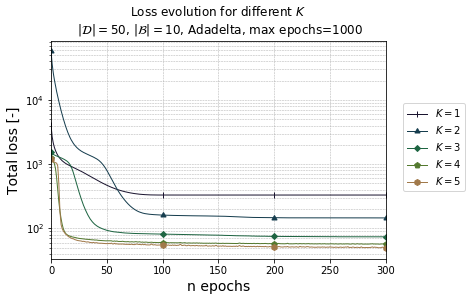

In [18]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
comparison_K_fig = plt.figure()

# Plot SGD
i = 0
for model in models[:]:  
    n_epoch = np.arange(np.shape(model.losses)[0])
    plt.semilogy(n_epoch, model.losses, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=100, label = '$K= {0} $'.format(model.nb_layers))
    print("For K={0} final loss is {1}".format(model.nb_layers, model.losses[-1]))
    i += 1

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n epochs', fontsize=14)
plt.ylabel('Total loss [-]', fontsize=14)
plt.xlim([0, 300])
#plt.ylim([0, 800])
plt.title('Loss evolution for different $K$ \n $|\mathcal{D}|=50$, $|\mathcal{B}|=10$, Adadelta, max epochs=1000')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

#comparison_K_fig.savefig('../report/figs/comparison_K.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Test on a bigger grid

In [20]:
# Grid size NxN
N = 64

# Use sufficiently high number of iterations to get ground truth solution
k_ground_truth = 20000

# Initialize Laplace problem on Square geometry
problem = DirichletProblem(N=N, k_ground_truth=20000)
B_idx = problem.B_idx
B = problem.B
f = problem.f

# Obtain solutions
ground_truth = problem.ground_truth

# Set initial_u equal for Jacobi method and for H method
initial_u = torch.ones(1,1,N,N)
k = 2000

# Obtain solution with Jacobi method
u_jacobi = im.jacobi_method(B_idx, B, f, initial_u, k = 2000)
print(f"Error after {k} iterations for Jacobi method: {LSE(ground_truth, u_jacobi)}")

# For each K obtain 
for model in models:
    u_H = im.H_method(model.net, B_idx, B, f, initial_u, k = 2000)
    print(f"Error after {k} iterations for H method with K={model.nb_layers}: {LSE(ground_truth, u_H)}")

Error after 2000 iterations for Jacobi method: 33.64340591430664
Error after 2000 iterations for H method with K=1: 7.877284957658048e-08
Error after 2000 iterations for H method with K=2: 1.012134731581682e-07
Error after 2000 iterations for H method with K=3: 1.0014544926661983e-07
Error after 2000 iterations for H method with K=4: 1.0188784216325075e-07
Error after 2000 iterations for H method with K=5: 1.0089386393019595e-07


# Plotting solutions for domain shapes 

## Plot Square Domain

2018-12-20 21:27:59,098 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf075c6d8>
2018-12-20 21:27:59,099 - matplotlib.colorbar - DEBUG - colorbar - Using auto colorbar locator on colorbar
2018-12-20 21:27:59,100 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf075c6d8>
2018-12-20 21:27:59,100 - matplotlib.colorbar - DEBUG - colorbar - Setting pcolormesh
2018-12-20 21:27:59,104 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,163 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,189 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,205 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,251 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,270 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:27:59,2

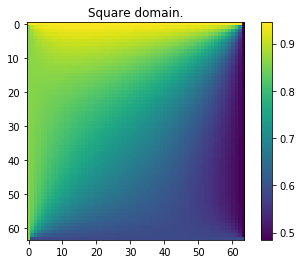

In [42]:
problem_square = DirichletProblem(N=N, k_ground_truth=20000)
ground_truth_square = problem_square.ground_truth.view(N, N).numpy()

square_fig = plt.figure()
im = plt.imshow(ground_truth_square)
plt.title("Square domain.")
plt.colorbar(im)

#square_fig.savefig('../report/figs/square.eps', bbox_inches='tight')
plt.draw()
plt.show()

## Plot L shape

2018-12-20 21:28:41,364 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf0534080>
2018-12-20 21:28:41,365 - matplotlib.colorbar - DEBUG - colorbar - Using auto colorbar locator on colorbar
2018-12-20 21:28:41,365 - matplotlib.colorbar - DEBUG - colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fecf0534080>
2018-12-20 21:28:41,366 - matplotlib.colorbar - DEBUG - colorbar - Setting pcolormesh
2018-12-20 21:28:41,370 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,416 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,445 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,468 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,515 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,539 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 21:28:41,5

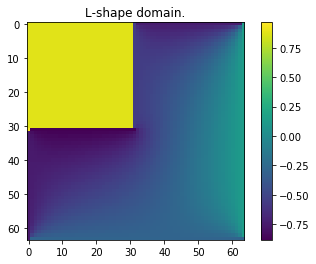

In [44]:
problem_l_shape = DirichletProblem(N=N, k_ground_truth=20000, domain_type = "l_shape")
ground_truth_l_shape = problem_l_shape.ground_truth.view(N, N).numpy()

square_fig = plt.figure()
im = plt.imshow(ground_truth_l_shape)
plt.title("L-shape domain.")
plt.colorbar(im)

#square_fig.savefig('../report/figs/l_shape.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Error evolution with iterations

In [21]:
tol = 1e-6
net = models[2].net

In [23]:
errors_H = []
max_iters = 10000

for model in models:
    u_H = initial_u
    err_H = LSE(ground_truth, u_H).item()
    errs_H = [err_H] 
    k_H = 0

    while err_H >= tol:
        u_H = im.H_method(model.net, B_idx, B, f, u_H, k = 1)
        err_H = LSE(ground_truth, u_H).item()
        errs_H.append(err_H)
        k_H += 1
        if k_H > max_iters or err_H == np.inf:
            print(f"H method, K = {model.nb_layers}: convergence not reached after {max_iters}, final error is {err_H}.")
            break
    
    print(f"H method, K = {model.nb_layers}: error of {tol} achieved after {k_H} iterations.")
    errors_H.append(errs_H)

H method, K = 1: error of 1e-06 achieved after 1863 iterations.
H method, K = 2: error of 1e-06 achieved after 840 iterations.
H method, K = 3: error of 1e-06 achieved after 486 iterations.
H method, K = 4: error of 1e-06 achieved after 379 iterations.
H method, K = 5: error of 1e-06 achieved after 312 iterations.


2018-12-20 20:53:44,524 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:53:44,526 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:44,527 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:44,537 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:44,538 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0,

2018-12-20 20:53:45,080 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,081 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:45,087 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,088 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:45,302 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,302 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:45,305 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:45,314 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:45,473 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,474 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:45,477 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,478 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.

2018-12-20 20:53:45,985 - matplotlib.axes._base - DEBUG - _base - update_title_pos
2018-12-20 20:53:45,987 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,988 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:45,992 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:45,993 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0,

2018-12-20 20:53:46,558 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,559 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:46,561 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,562 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:46,779 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,779 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
2018-12-20 20:53:46,782 - matplotlib.ticker - DEBUG - ticker - vmin 1e-06 vmax 7846.3623046875
2018-12-20 20:53:46,783 - matplotlib.ticker - DEBUG - ticker - ticklocs [2e-07, 3e-07, 4e-07, 5e-07, 6e-07, 7e-07, 8e-07, 9e-07, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.

2018-12-20 20:53:46,992 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:46,994 - matplotlib.ticker - DEBUG - ticker - ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
2018-12-20 20:53:46,997 - matplotlib.ticker - DEBUG - ticker - vmin 0.6351622995324107 vmax 13785.452956584368
2018-12-20 20:53:46,998 - matplotlib.ticker - DEBUG - ticker - ticklocs [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.

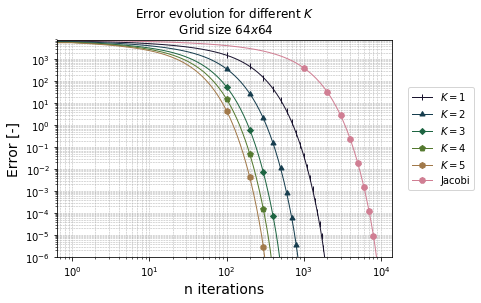

In [29]:
# Colors for plotting
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

# Initilize figure
error_k_fig = plt.figure()

i = 0
for error in errors_H:  
    n_iter = np.arange(np.shape(error)[0])
    plt.loglog(n_iter, error, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=100, label = '$K= {0} $'.format(models[i].nb_layers))
    i += 1

# Plot error evolution for Jacobi 
n_iter = np.arange(np.shape(errs_jacobi)[0])
plt.loglog(n_iter, errs_jacobi, color=colors[i], linewidth=1, linestyle="-", marker=(i+2, 0, 0), markevery=1000, label = 'Jacobi')

# Additional settings
plt.legend(bbox_to_anchor=(1.05, 0.31), loc=3, borderaxespad=0.)
plt.xlabel('n iterations', fontsize=14)
plt.ylabel('Error [-]', fontsize=14)
#plt.xlim([0, max_epochs])
plt.ylim([tol, errors_H[0][0]])
plt.title('Error evolution for different $K$\n Grid size ${0}x{0}$'.format(N))
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

#error_k_fig.savefig('../report/figs/error_k.eps', bbox_inches='tight')
plt.draw()
plt.show()

# Model testing

In [5]:
tol = 1e-6
if base_parameters is None:
    raise ValueError("Execute cell with base parameters")

_base_data_path_ = '../report/data/'
_base_fig_path_ = '../report/figs/'

if not os.path.exists(_base_data_path_):
    os.makedirs(_base_data_path_)
    

def obtain_test_results(mdl, grid_size, nb_tests=50, domain_shape='square', nb_layers=4, force=False, plot=False):
    data_path = f'{_base_data_path_}nb_layers_{nb_layers}_grid_{grid_size}_domain_{domain_shape}.pkl'
    
    if force or not os.path.exists(data_path):
        test_results = MT.test_results_pd(mdl, nb_tests, grid_size, tol=tol, convergence_tol=1e-12)
        test_results['grid_size'] = grid_size
        test_results['shape'] = domain_shape
        test_results.to_pickle(data_path)
    else:
        test_results = pd.read_pickle(data_path)


    if plot:
        test_results['iters_ratio'] = test_results['nb_iters_convjac'] / test_results['nb_iters_jac'] 
        ax = sns.boxplot(data=test_results[['flops_ratio', 'cpu_time_ratio', 'iters_ratio']]\
                         .rename(columns={'flops_ratio': 'Ratio of FLOPS', 'cpu_time_ratio': 'Ratio of CPU time', 'iters_ratio': 'Ratio of #iterations'}), orient="h", palette="Set2")
        ax.set_title(f'Test results for grid size: {grid_size}')
        plt.savefig(f'{_base_fig_path_}grid_{grid_size}_domain_{domain_shape}.eps')
        display(ax)
    return test_results


def agg_for_layer(base_parameters, nb_layers, problem_instances, grid_sizes, nb_tests=20):
    mdl = M.JacobyWithConv(**{**base_parameters, **{'max_epochs': 1000, 'optimizer': 'Adadelta', 'nb_layers': nb_layers}})\
           .fit(problem_instances)
    
    test_results = [obtain_test_results(mdl, grid_size=grid_size, domain_shape=shape, nb_tests=nb_tests, nb_layers=nb_layers, plot=True, force=True) 
         for grid_size, shape in product(grid_sizes, ['l_shape', 'square'])]

    d = {'flops_ratio': 'FLOPS ratio', 'cpu_time_ratio': 'CPU time ratio', 'nb_iters_jac': 'nb iters existent solver', 'nb_iters_convjac': 'nb iters trained solver'}
    ts_concat = pd.concat(test_results).rename(columns=d)
    ta = ts_concat.groupby(['grid_size', 'shape'])[list(d.values())].mean().reset_index().rename(columns={'grid': 'grid size'})
    ta['nb_layers'] = nb_layers
    ts_concat['nb_layers'] = nb_layers
    return ta, ts_concat

2018-12-30 12:11:22,390 - root - INFO - model - Using optimizer Adadelta
2018-12-30 12:11:22,635 - root - INFO - model - Training with max_epochs: 1000, tol: 1e-06. Initial loss is 16156.76171875
2018-12-30 12:11:22,900 - root - INFO - model - iter 0 with total loss 4020.325927734375
2018-12-30 12:11:53,918 - root - INFO - model - iter 100 with total loss 330.5577392578125
2018-12-30 12:12:27,959 - root - INFO - model - iter 200 with total loss 330.51593017578125
2018-12-30 12:12:59,013 - root - INFO - model - iter 300 with total loss 330.52191162109375
2018-12-30 12:13:29,859 - root - INFO - model - iter 400 with total loss 330.525146484375
2018-12-30 12:13:59,377 - root - INFO - model - iter 500 with total loss 330.5161437988281
2018-12-30 12:14:27,941 - root - INFO - model - iter 600 with total loss 330.5220642089844
2018-12-30 12:14:57,593 - root - INFO - model - iter 700 with total loss 330.5196228027344
2018-12-30 12:15:29,529 - root - INFO - model - iter 800 with total loss 330.

2018-12-30 12:28:24,678 - root - INFO - model_testing - Jacobi method  converged but did not reach required tol


2018-12-30 12:30:20,434 - root - INFO - model - Using optimizer Adadelta
2018-12-30 12:30:20,561 - root - INFO - model - Training with max_epochs: 1000, tol: 1e-06. Initial loss is 1111510.625
2018-12-30 12:30:20,919 - root - INFO - model - iter 0 with total loss 57557.74609375
2018-12-30 12:30:58,496 - root - INFO - model - iter 100 with total loss 160.8571319580078
2018-12-30 12:31:34,744 - root - INFO - model - iter 200 with total loss 146.26608276367188
2018-12-30 12:32:09,306 - root - INFO - model - iter 300 with total loss 145.5672607421875
2018-12-30 12:32:43,366 - root - INFO - model - iter 400 with total loss 136.31167602539062
2018-12-30 12:33:18,496 - root - INFO - model - iter 500 with total loss 134.05670166015625
2018-12-30 12:33:54,237 - root - INFO - model - iter 600 with total loss 134.09120178222656
2018-12-30 12:34:28,789 - root - INFO - model - iter 700 with total loss 134.06448364257812
2018-12-30 12:35:05,854 - root - INFO - model - iter 800 with total loss 134.10

2018-12-30 12:47:49,175 - root - INFO - model_testing - Jacobi method  converged but did not reach required tol


2018-12-30 12:49:51,133 - root - INFO - model - Using optimizer Adadelta
2018-12-30 12:49:51,287 - root - INFO - model - Training with max_epochs: 1000, tol: 1e-06. Initial loss is 2754.449462890625
2018-12-30 12:49:51,650 - root - INFO - model - iter 0 with total loss 1539.9169921875
2018-12-30 12:50:38,511 - root - INFO - model - iter 100 with total loss 81.43997192382812
2018-12-30 12:51:20,304 - root - INFO - model - iter 200 with total loss 74.87944030761719
2018-12-30 12:52:24,303 - root - INFO - model - iter 300 with total loss 73.74588775634766
2018-12-30 12:53:35,481 - root - INFO - model - iter 400 with total loss 73.66825103759766
2018-12-30 12:54:33,431 - root - INFO - model - iter 500 with total loss 73.65039825439453
2018-12-30 12:55:32,501 - root - INFO - model - iter 600 with total loss 73.71232604980469
2018-12-30 12:56:20,673 - root - INFO - model - iter 700 with total loss 73.72443389892578
2018-12-30 12:57:01,643 - root - INFO - model - iter 800 with total loss 73.6

2018-12-30 13:09:11,380 - root - INFO - model_testing - Jacobi method  converged but did not reach required tol


2018-12-30 13:11:09,740 - root - INFO - model - Using optimizer Adadelta
2018-12-30 13:11:09,967 - root - INFO - model - Training with max_epochs: 1000, tol: 1e-06. Initial loss is 1346.889404296875
2018-12-30 13:11:10,591 - root - INFO - model - iter 0 with total loss 1251.7584228515625
2018-12-30 13:12:20,624 - root - INFO - model - iter 100 with total loss 60.05453109741211
2018-12-30 13:13:27,075 - root - INFO - model - iter 200 with total loss 57.559566497802734
2018-12-30 13:14:33,172 - root - INFO - model - iter 300 with total loss 56.826072692871094
2018-12-30 13:15:39,478 - root - INFO - model - iter 400 with total loss 56.52799606323242
2018-12-30 13:16:45,750 - root - INFO - model - iter 500 with total loss 56.39349365234375
2018-12-30 13:17:52,612 - root - INFO - model - iter 600 with total loss 56.54300308227539
2018-12-30 13:18:59,540 - root - INFO - model - iter 700 with total loss 56.00718307495117
2018-12-30 13:20:11,298 - root - INFO - model - iter 800 with total loss

2018-12-30 13:36:41,295 - root - INFO - model_testing - Jacobi method  converged but did not reach required tol


2018-12-30 13:39:36,977 - root - INFO - model - Using optimizer Adadelta
2018-12-30 13:39:37,393 - root - INFO - model - Training with max_epochs: 1000, tol: 1e-06. Initial loss is 1254.5662841796875
2018-12-30 13:39:38,186 - root - INFO - model - iter 0 with total loss 1213.55517578125
2018-12-30 13:41:15,092 - root - INFO - model - iter 100 with total loss 54.51945877075195
2018-12-30 13:42:54,044 - root - INFO - model - iter 200 with total loss 51.37683868408203
2018-12-30 13:44:33,837 - root - INFO - model - iter 300 with total loss 49.83615493774414
2018-12-30 13:46:08,817 - root - INFO - model - iter 400 with total loss 48.633155822753906
2018-12-30 13:47:35,524 - root - INFO - model - iter 500 with total loss 47.73637390136719
2018-12-30 13:48:45,463 - root - INFO - model - iter 600 with total loss 48.50999450683594
2018-12-30 13:49:39,876 - root - INFO - model - iter 700 with total loss 47.72964096069336
2018-12-30 13:50:33,307 - root - INFO - model - iter 800 with total loss 4

2018-12-30 14:03:18,404 - root - INFO - model_testing - Jacobi method  converged but did not reach required tol


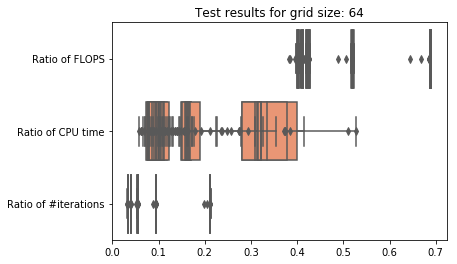

In [6]:
cols = [
 'nb_layers',
 'grid size',
 'shape',
 'FLOPS ratio',
 'CPU time ratio',
 'nb iters existent solver',
 'nb iters trained solver'
]

#nb_problem_instances = 100
#problem_instances_n16 = [DirichletProblem(k=k, N=16) for k in np.random.randint(1, 20, nb_problem_instances)]
#problem_instances_n16 = [DirichletProblem(k=k, N=16) for k in np.random.randint(1, 20, nb_problem_instances)]

ts = [agg_for_layer(base_parameters, grid_sizes=[32, 64], nb_layers=l, problem_instances=problem_instances) for l in range(1, 6)]
#final_results = pd.concat([agg_for_layer(l, problem_instances=problem_instances)[0] for l in range(1, 5)])[cols]

#final_results.to_pickle('./data/final_test_results.pkl')

In [7]:
agg, raw = zip(*ts)


raw = pd.concat(raw)
agg = pd.concat(agg)
agg

grid_size    shape  FLOPS ratio  CPU time ratio  nb iters existent solver  \
0         32  l_shape     0.688194        0.307704                   1963.15   
1         32   square     0.688230        0.331942                   1938.25   
2         64  l_shape     0.688738        0.351334                   8721.20   
3         64   square     0.685782        0.327067                   8756.55   
0         32  l_shape     0.518435        0.161434                   1963.15   
1         32   square     0.518144        0.170808                   1938.25   
2         64  l_shape     0.521290        0.164615                   8721.20   
3         64   square     0.519136        0.182762                   8756.55   
0         32  l_shape     0.421221        0.106157                   1963.15   
1         32   square     0.421041        0.100973                   1938.25   
2         64  l_shape     0.426367        0.115397                   8721.20   
3         64   square     0.424574        0.115839                   8756.55   
0         32  l_shape     0.401142        0.108883                   1963.15   
1         32   square     0.401129        0.094961                   1938.25   
2         64  l_shape     0.408428        0.097089                   8721.20   
3         64   square     0.406841        0.097863                   8756.55   
0         32  l_shape     0.402174        0.078399                   1963.15   
1         32   square     0.402281        0.082698                   1938.25   
2         64  l_shape     0.411552        0.088051                   8721.20   
3         64   square     0.409813        0.090584                   8756.55   

   nb iters trained solver  nb_layers  
0                   415.70          1  
1                   410.45          1  
2                  1848.20          1  
3                  1847.45          1  
0                   185.05          2  
1                   182.60          2  
2                   826.60          2  
3                   826.40          2  
0                   106.70          3  
1                   105.30          3  
2                   479.80          3  
3                   479.65          3  
0                    78.75          4  
1                    77.75          4  
2                   356.20          4  
3                   356.20          4  
0                    64.45          5  
1                    63.65          5  
2                   293.00          5  
3                   292.90          5

## Tables plots for report

In [106]:
from nnpde.utils.misc import flatten
_t = raw.groupby(['nb_layers', 'grid_size', 'shape'])['FLOPS ratio', 'CPU time ratio', 'nb iters ratio'].agg(['mean', 'std'])
_t = pd.DataFrame(data=_t.reset_index().values, columns=['nb_layers', 'grid_size', 'shape'] + flatten([[c + ' mean', c + ' std'] for c in ['FLOPS ratio', 'CPU time ratio', 'nb iters ratio']]))
for c in ['FLOPS ratio', 'CPU time ratio', 'nb iters ratio']:
    _t[c] = _t[[p for p in _t.columns if c in p]].apply(lambda row: "\${0:1.3f}\pm{1:1.3f}\$".format(row[0], row[1]), axis=1)

print(_t[['nb_layers', 'grid_size', 'shape', 'FLOPS ratio', 'CPU time ratio', 'nb iters ratio']]\
    .set_index(['nb_layers', 'grid_size', 'shape']).to_latex(multirow=True))

\begin{tabular}{llllll}
\toprule
  &    &        &        FLOPS ratio &     CPU time ratio &     nb iters ratio \\
nb\_layers & grid\_size & shape &                    &                    &                    \\
\midrule
\multirow{4}{*}{1} & \multirow{2}{*}{32} & l\_shape &  \textbackslash \$0.688\textbackslash pm0.001\textbackslash \$ &  \textbackslash \$0.308\textbackslash pm0.064\textbackslash \$ &  \textbackslash \$0.212\textbackslash pm0.000\textbackslash \$ \\
  &    & square &  \textbackslash \$0.688\textbackslash pm0.000\textbackslash \$ &  \textbackslash \$0.332\textbackslash pm0.097\textbackslash \$ &  \textbackslash \$0.212\textbackslash pm0.000\textbackslash \$ \\
\cline{2-6}
  & \multirow{2}{*}{64} & l\_shape &  \textbackslash \$0.689\textbackslash pm0.001\textbackslash \$ &  \textbackslash \$0.351\textbackslash pm0.053\textbackslash \$ &  \textbackslash \$0.212\textbackslash pm0.000\textbackslash \$ \\
  &    & square &  \textbackslash \$0.686\textbackslash pm0.011\textb

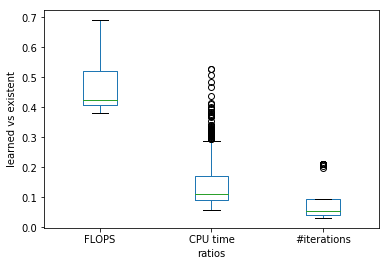

In [108]:
raw['nb iters ratio'] = raw['nb iters trained solver'] / raw['nb iters existent solver']
ax = raw[['FLOPS ratio', 'CPU time ratio', 'nb iters ratio']].plot.box()
ax.set_xticklabels(['FLOPS', 'CPU time', '#iterations'])
ax.set_xlabel('ratios')
plt.ylabel('learned vs existent')
plt.savefig(f'{_base_fig_path_}/ratio_plot.eps')
#plt.xticks(rotation=45)